In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=FutureWarning)

# Contexto
El proyecto busca identificar aquellas transacciones bancarias que son fraudulentas, con la finalidad de generar medidas preventivas

# Objetivo

Plantear distintos modelos, evaluar sus metricas y escoger uno para realizar las predicciones


# ETL

In [3]:
df = pd.read_csv('fraude_bacario.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Se revisa el tipo de dato

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

se verifican si hay valores duplicados

In [7]:
df.duplicated().sum()

0

Creando una nueva columna type2 conn las iniciales de 'nameOrig' y 'nameDest'

In [8]:
df['type2'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
columna = df['type2']
del df['type2']
df.insert(2,'type2', columna) # se mueve la columna a la posicion 2 para tener mas orden
df.head()

,step,type,type2,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,CM,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,CM,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,CC,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,CC,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,CM,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Se transforma la columnna step en las columnans dia y hora

In [9]:
df['day'] = (df['step']-1)//24+1
df['hour'] = (df['step']-1) % 24
df.drop(columns= 'step', inplace=True)
df.sample(5)

,type,type2,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour
2628181,CASH_OUT,CC,197261.88,C1740704847,0.0,0.0,C848513566,1256404.80,1453666.68,0,0,9,16
2510324,TRANSFER,CC,33581.74,C83613427,0.0,0.0,C1258306078,4224671.24,4258252.97,0,0,9,12
4595772,PAYMENT,CM,5046.15,C2095044052,0.0,0.0,M1127484486,0.00,0.00,0,0,14,15
2491984,PAYMENT,CM,5522.28,C1875044696,0.0,0.0,M1311566647,0.00,0.00,0,0,9,11
4811341,CASH_OUT,CC,319790.06,C1940991213,0.0,0.0,C1386793187,893426.32,1213216.38,0,0,15,9


Se eliminan columnas innecesarias

In [10]:
df.drop(columns=['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], inplace=True)

### Se verifica cuantos tipos de type y type2 hay

In [11]:
df['type'].value_counts().size

5

In [12]:
df['type2'].value_counts().size

2

In [13]:
df.head(3)

,type,type2,amount,isFraud,day,hour
0,PAYMENT,CM,9839.64,0,1,0
1,PAYMENT,CM,1864.28,0,1,0
2,TRANSFER,CC,181.00,1,1,0


### Se convierte las columnas type y type2 en formato numerico, se van preparando los datos para los modelos de Machine Learning

In [14]:
df = pd.get_dummies(df, columns=['type', 'type2'],  dtype=int)

In [15]:
df.head()

,amount,isFraud,day,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,9839.64,0,1,0,0,0,0,1,0,0,1
1,1864.28,0,1,0,0,0,0,1,0,0,1
2,181.00,1,1,0,0,0,0,0,1,1,0
3,181.00,1,1,0,0,1,0,0,0,1,0
4,11668.14,0,1,0,0,0,0,1,0,0,1


verificación de duplicados

In [16]:
df.duplicated().sum()

7597

se eliminan los duplicados

In [17]:
df.drop_duplicates(inplace=True)

## Matriz de correlación inicial

In [18]:
matriz_correlacion_inicial = df.corr()

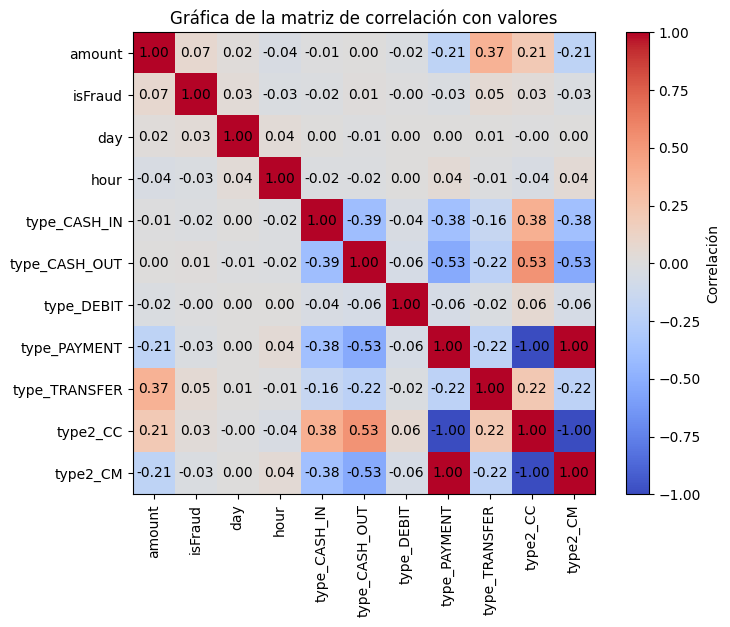

In [19]:
def grafico_matriz_correlacion(matriz):
    plt.figure(figsize=(8, 6))
    plt.imshow(matriz, cmap='coolwarm', interpolation='nearest')
    plt.xticks(np.arange(len(matriz.columns)), matriz.columns, rotation=90)
    plt.yticks(np.arange(len(matriz.columns)), matriz.columns)
    plt.colorbar(label='Correlación')
    plt.title('Gráfica de la matriz de correlación con valores')
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(j, i, f'{matriz.iloc[i, j]:.2f}', ha='center', va='center', color='black')
    plt.show()


grafico_matriz_correlacion(matriz_correlacion_inicial)

# EDA
Se realiza un boxplot de las columnas: 'isFraud', 'amount', 'step'

In [20]:
# fig, axs = plt.subplots(1, 3, figsize= (15, 5))
# fig.suptitle('Boxplots', fontsize=20, y=1.05)
# sns.boxplot (x= 'isFraud', data = df, ax=axs[0]).set_title('Fraude', fontsize=12, y=1.02)
# sns.boxplot (x= 'amount', data = df, ax=axs[1]).set_title('Monto', fontsize=12, y=1.02)
# sns.boxplot (x= 'step', data = df, ax=axs[2]).set_title('Hora del mes', fontsize=12, y=1.02);


### Se crea una matriz de correlación

### Se verifica si esta balanceada la etiqueta objetivo

In [21]:
distribucion_isFraud = df['isFraud'].value_counts()
distribucion_isFraud

isFraud
0    6346920
1       8103
Name: count, dtype: int64

In [22]:
f'{round((8213/6354407)*100, 2)} %'

'0.13 %'

Como se observa solo el 0.13% de los datos de la etiqueta objetivo pertenecen a la categoria fraude, por lo tannto es necesario balancear los datos

Ahora observamos el desbalanceo graficamente

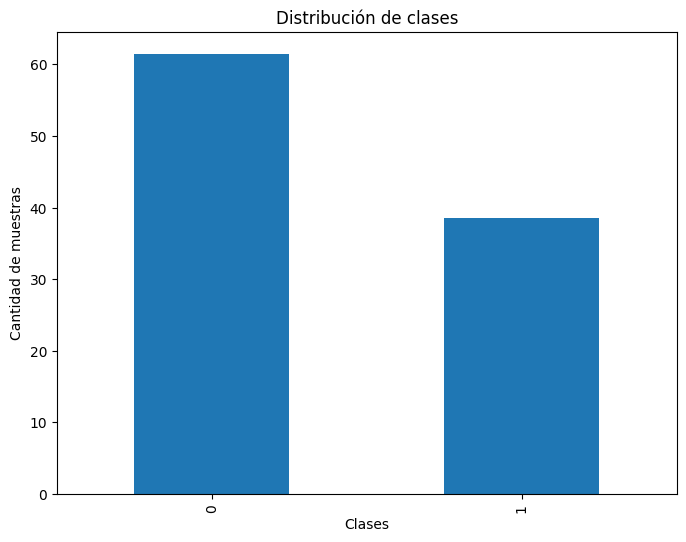

In [39]:
plt.figure(figsize=(8, 6))
distribucion_isFraud.plot(kind='bar') 
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad de muestras');

### Balanceando la etiqueta objetivo

In [24]:
# se toma una muestra de 4.5M
df1 = df[df['isFraud']==1]
df1 = pd.concat([df1, df[df['isFraud']==0].sample(4500000)])
df1.shape

(4508103, 11)

In [25]:
df1.duplicated().sum()

0

Se hace un oversampling de la clase minoritaria

Antes de SMOTE: 4500000 clase mayoritaria,  8103 clase minoritaria
Después de SMOTE: 4500000 clase mayoritaria,  3600000 clase minoritaria
Cantidad de duplicados: 780342


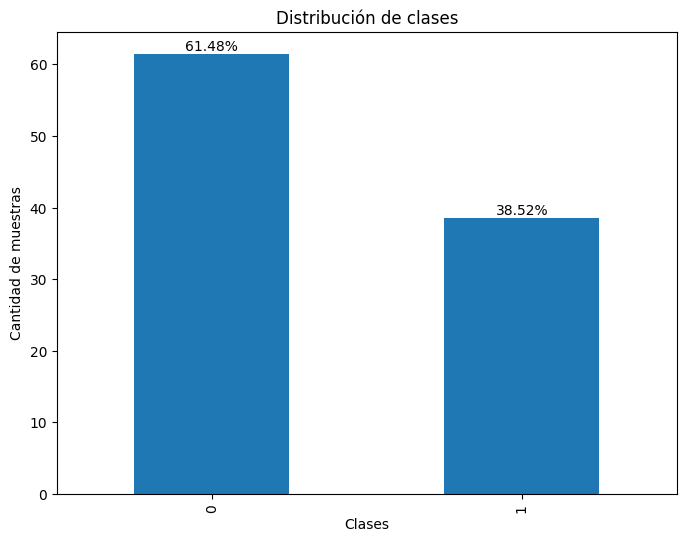

In [26]:
from imblearn.over_sampling import SMOTE
def balanceo_clases(df, porcetaje_resampleo):

    # Instancia SMOTE
    X = df1.drop(columns= 'isFraud')
    y = df1['isFraud']
    smote = SMOTE(sampling_strategy=porcetaje_resampleo, random_state=42)

    # Aplica SMOTE al conjunto de datos
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Verifica el nuevo balance de clases
    print("Antes de SMOTE:", sum(y == 0), "clase mayoritaria, ", sum(y == 1), "clase minoritaria")
    print("Después de SMOTE:", sum(y_resampled == 0), "clase mayoritaria, ", sum(y_resampled == 1), "clase minoritaria")
    df_balanceado = pd.DataFrame(X_resampled, columns=X.columns)
    df_balanceado['isFraud'] = y_resampled
    
    # se verifican cuatos duplicados hay y se borran
    print(f'Cantidad de duplicados: {df_balanceado.duplicated().sum()}')
    
    # y se borran
    df_balanceado.drop_duplicates(inplace=True)
    
    #datos para graficar
    distribucion_isFraud = df_balanceado['isFraud'].value_counts()
    distribucion_isFraud
    
    #grafico
    plt.figure(figsize=(8, 6))
    distribucion_isFraud = df_balanceado['isFraud'].value_counts(normalize=True)*100
    ax = distribucion_isFraud.plot(kind='bar')
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5,
            f'{round(i.get_height(), 2)}%', ha='center')
    plt.title('Distribución de clases')
    plt.xlabel('Clases')
    plt.ylabel('Cantidad de muestras');
    return df_balanceado
df_balanceado = balanceo_clases(df1, 0.8)

In [40]:
df_balanceado.shape

(7319658, 11)

In [41]:
df_balanceado.head(5)

,amount,day,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,-0.427457,1,0,0,0,0,0,1,1,0,1
1,-0.427457,1,0,0,1,0,0,0,1,0,1
2,-0.425435,1,0,0,0,0,0,1,1,0,1
3,-0.425435,1,0,0,1,0,0,0,1,0,1
4,-0.412094,1,0,0,0,0,0,1,1,0,1


Se realiza la matriz de correlación

In [42]:
matriz_correlacion = df_balanceado.corr()

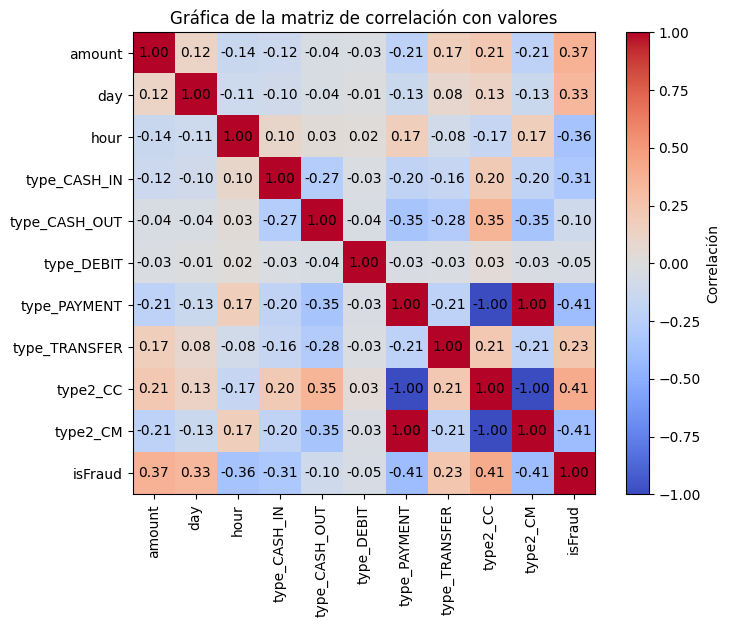

In [43]:
grafico_matriz_correlacion(matriz_correlacion)

Existe correlación entre algunas variables

Se aplica un Standar Sacaler a la columna amount

In [31]:
# Seleccionar la etiqueta a normalizar
etiqueta_a_normalizar = 'amount'

# Inicializar StandardScaler
scaler = StandardScaler()

# Ajustar el escalador solo a la etiqueta
scaler.fit(df_balanceado[[etiqueta_a_normalizar]])

# Transformar la etiqueta
df_balanceado[etiqueta_a_normalizar] = scaler.transform(df_balanceado[[etiqueta_a_normalizar]])

# Ver el DataFrame resultante
df_balanceado.head()

,amount,day,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,-0.427457,1,0,0,0,0,0,1,1,0,1
1,-0.427457,1,0,0,1,0,0,0,1,0,1
2,-0.425435,1,0,0,0,0,0,1,1,0,1
3,-0.425435,1,0,0,1,0,0,0,1,0,1
4,-0.412094,1,0,0,0,0,0,1,1,0,1


In [32]:
df_balanceado.head(10)

,amount,day,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,-0.427457,1,0,0,0,0,0,1,1,0,1
1,-0.427457,1,0,0,1,0,0,0,1,0,1
2,-0.425435,1,0,0,0,0,0,1,1,0,1
3,-0.425435,1,0,0,1,0,0,0,1,0,1
4,-0.412094,1,0,0,0,0,0,1,1,0,1
5,-0.412094,1,0,0,1,0,0,0,1,0,1
6,-0.107197,1,0,0,1,0,0,0,1,0,1
7,0.556096,1,0,0,0,0,0,1,1,0,1
8,0.556096,1,0,0,1,0,0,0,1,0,1
9,-0.400590,1,0,0,0,0,0,1,1,0,1


Se guarda el dataset procesado

In [33]:
df_balanceado.to_csv('balanced_data.csv', index=False)